In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import vgg16
import copy
import tqdm
import os
import matplotlib
import pandas as pd
from torchsummary import summary
from timeit import default_timer as timer
import copy

In [2]:
transform_train = transforms.Compose(
    [transforms.Pad(4),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomGrayscale(),
     transforms.RandomCrop(32, padding=4),
])
 
transform_test = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)
 
device = torch.device("cpu")
 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=24, shuffle=True)
 
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testLoader = torch.utils.data.DataLoader(testset, batch_size=24, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
num_epochs = 40
total = 0
accuracy_rate = []
 
def test():
    model.eval()
    correct = 0  # 预测正确的图片数
    total = 0  # total number of pictures
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            images = images.to(device)
            outputs = model(images).to(device)
            outputs = outputs.cpu()
            outputarr = outputs.numpy()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    accuracy = 100 * correct / total
    accuracy_rate.append(accuracy)
    print(f'Accuracy is:{accuracy}%'.format(accuracy))

In [4]:
model = vgg16(pretrained=True)

D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Train
# model.load_state_dict(torch.load('CIFAR-model/VGG16.pth'))
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-3)
loss_func = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.4, last_epoch=-1)

for epoch in range(num_epochs):
    model.train()
    model.to(device)
    running_loss = 0.0
    total_correct = 0
    total_trainset = 0
 
    for i, (data, labels) in enumerate(trainLoader, 0):
        data = data.to(device)
        outputs = model(data).to(device)
        labels = labels.to(device)
        loss = loss_func(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, pred = outputs.max(1)
        correct = (pred == labels).sum().item()
        total_correct += correct
        total_trainset += data.shape[0]
        if i % 1000 == 0 and i > 0:
            print(f"{i}th Training, running_loss={running_loss}".format(i, running_loss))
            running_loss = 0.0
    test()
    scheduler.step()

1000th Training, running_loss=1444.8376440107822
2000th Training, running_loss=831.410417035222
Accuracy is:77.86000061035156%
1000th Training, running_loss=693.0993446707726
2000th Training, running_loss=632.3288294821978
Accuracy is:78.62000274658203%
1000th Training, running_loss=585.5471361353993
2000th Training, running_loss=561.6243983954191
Accuracy is:82.22000122070312%
1000th Training, running_loss=533.3385413736105
2000th Training, running_loss=528.9425534233451
Accuracy is:77.52999877929688%
1000th Training, running_loss=502.9279771745205
2000th Training, running_loss=517.8734045103192
Accuracy is:86.30000305175781%
1000th Training, running_loss=377.6968470402062
2000th Training, running_loss=390.1512226611376
Accuracy is:88.16999816894531%
1000th Training, running_loss=366.75395810976624
2000th Training, running_loss=371.00160704925656
Accuracy is:86.63999938964844%
1000th Training, running_loss=353.2822380065918
2000th Training, running_loss=367.5567024797201
Accuracy is:8

In [7]:
torch.save(model.state_dict(), r'.\vgg16_2.pth')

In [5]:
state_dict = torch.load(r'.\vgg16_2.pth')
print(state_dict.keys())

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])


In [6]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
import torch.nn.utils.prune as prune

In [8]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std),
            ]
            )
BATCH = 32
NUM_WORKERS = 8

In [10]:
cifar10_train = torchvision.datasets.CIFAR10(root='CIFAR10/train', train= True, download= True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(root='CIFAR10/test', train= False, download= True, transform=transform)

# train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
df = pd.DataFrame.from_dict(data=cifar10_test.class_to_idx, columns=[ 'Id'], orient ='index' )
display(df)

,Id
airplane,0
automobile,1
bird,2
cat,3
deer,4
dog,5
frog,6
horse,7
ship,8
truck,9


In [12]:
dataset_info = { 'Total training data':cifar10_train.data.shape[0], 'Total test data': cifar10_test.data.shape[0], 'Img Dimension': cifar10_test.data.shape[1:]}
display(pd.DataFrame.from_dict(dataset_info, orient='index', columns=['Explanation']))

,Explanation
Total training data,50000
Total test data,10000
Img Dimension,"(32, 32, 3)"


In [13]:
def get_cpu_inference_time_and_test_acc(model, test_loader):
    test_data_size = len(testLoader.dataset)
    cpu_device = torch.device("cpu")
    model = model.to(cpu_device)
    # Wam-up
    # Because I sequentially run each cell above, and they includes for loop, I assume the CPU is warmed up
#     torch.cuda.synchronize()
    elapsed_time_ms = 0
    start = timer()
    # Start Inference Phase
    correct = 0
    with torch.no_grad():
        for imgs, labels in tqdm.tqdm(test_loader):
#             imgs, labels = imgs.cuda(), labels.cuda()
            imgs, labels = imgs.to(cpu_device), labels.to(cpu_device)
            out = model(imgs.float())
            predictions = out.argmax(dim=1, keepdim=True)  
            correct += predictions.eq(labels.view_as(predictions)).sum().item()
#             break
    accuracy = correct/len(test_loader.dataset)
    print(accuracy)
    # End of inference Phase
#     torch.cuda.synchronize()
    end = timer()
    elapsed_time_ms = (end - start) * 1000
    per_sample = elapsed_time_ms/test_data_size
    print("CPU Inference time is " + str(per_sample)+ ' ms')
    return per_sample, accuracy

In [43]:
# Original Model
torch.cuda.empty_cache()
criterion=torch.nn.CrossEntropyLoss()
model.eval()
cpu_inf_time, acc = get_cpu_inference_time_and_test_acc(model, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:41<00:00,  7.63it/s]

0.9087
CPU Inference time is 4.103978110000003 ms


In [14]:
parameters_to_prune1 =[] # 0.1
parameters_to_prune2 =[] # 0.3
parameters_to_prune3 =[] # 0.5
parameters_to_prune4 =[] # 0.7
parameters_to_prune5 =[] # 0.9

compressed_model1 = copy.deepcopy(model)
compressed_model2 = copy.deepcopy(model)
compressed_model3 = copy.deepcopy(model)
compressed_model4 = copy.deepcopy(model)
compressed_model5 = copy.deepcopy(model)

In [15]:
for module_name, module in compressed_model1.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            parameters_to_prune1.append((module,"weight"))

for module_name, module in compressed_model2.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            parameters_to_prune2.append((module,"weight"))

for module_name, module in compressed_model3.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            parameters_to_prune3.append((module,"weight"))
            
for module_name, module in compressed_model4.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            parameters_to_prune4.append((module,"weight"))

for module_name, module in compressed_model5.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            parameters_to_prune5.append((module,"weight"))

In [16]:
parameters_to_prune1 = tuple(parameters_to_prune1)
parameters_to_prune2 = tuple(parameters_to_prune2)
parameters_to_prune3 = tuple(parameters_to_prune3)
parameters_to_prune4 = tuple(parameters_to_prune4)
parameters_to_prune5 = tuple(parameters_to_prune5)

In [17]:
prune.global_unstructured(
        parameters_to_prune1,
        pruning_method=prune.L1Unstructured,
        amount=0.1,
    )

prune.global_unstructured(
        parameters_to_prune2,
        pruning_method=prune.L1Unstructured,
        amount=0.3,
    )

prune.global_unstructured(
        parameters_to_prune3,
        pruning_method=prune.L1Unstructured,
        amount=0.5,
    )

prune.global_unstructured(
        parameters_to_prune4,
        pruning_method=prune.L1Unstructured,
        amount=0.7,
    )

prune.global_unstructured(
        parameters_to_prune5,
        pruning_method=prune.L1Unstructured,
        amount=0.9,
    )

In [18]:
for module_name, module in compressed_model1.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.remove(module, 'weight')
            
for module_name, module in compressed_model2.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.remove(module, 'weight')
            
for module_name, module in compressed_model3.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.remove(module, 'weight')
            
for module_name, module in compressed_model4.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.remove(module, 'weight')
            
for module_name, module in compressed_model5.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.remove(module, 'weight')

In [19]:
torch.save(compressed_model1.state_dict(), r'.\vgg16_compressed1_pruning.pth')
torch.save(compressed_model2.state_dict(), r'.\vgg16_compressed2_pruning.pth')
torch.save(compressed_model3.state_dict(), r'.\vgg16_compressed3_pruning.pth')
torch.save(compressed_model4.state_dict(), r'.\vgg16_compressed4_pruning.pth')
torch.save(compressed_model5.state_dict(), r'.\vgg16_compressed5_pruning.pth')

In [37]:
torch.cuda.empty_cache()
criterion=torch.nn.CrossEntropyLoss()
compressed_model1.eval()
cpu_inf_time1, acc1 = get_cpu_inference_time_and_test_acc(compressed_model1, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:40<00:00,  7.74it/s]

0.909
CPU Inference time is 4.044142030000001 ms


In [38]:
torch.cuda.empty_cache()
criterion=torch.nn.CrossEntropyLoss()
compressed_model2.eval()
cpu_inf_time2, acc2 = get_cpu_inference_time_and_test_acc(compressed_model2, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:40<00:00,  7.71it/s]

0.9066
CPU Inference time is 4.06103751999999 ms


In [39]:
torch.cuda.empty_cache()
criterion=torch.nn.CrossEntropyLoss()
compressed_model3.eval()
cpu_inf_time3, acc3 = get_cpu_inference_time_and_test_acc(compressed_model3, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:40<00:00,  7.80it/s]

0.9022
CPU Inference time is 4.013130460000002 ms


In [40]:
torch.cuda.empty_cache()
criterion=torch.nn.CrossEntropyLoss()
compressed_model4.eval()
cpu_inf_time4, acc4 = get_cpu_inference_time_and_test_acc(compressed_model4, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:40<00:00,  7.80it/s]

0.8551
CPU Inference time is 4.012443949999999 ms


In [41]:
torch.cuda.empty_cache()
criterion=torch.nn.CrossEntropyLoss()
compressed_model5.eval()
cpu_inf_time5, acc5 = get_cpu_inference_time_and_test_acc(compressed_model5, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:40<00:00,  7.82it/s]

0.1
CPU Inference time is 4.001661149999996 ms


In [44]:
cpu_data = {'l1_unstructed': [cpu_inf_time,
                              cpu_inf_time1, 
                              cpu_inf_time2,
                              cpu_inf_time3,
                              cpu_inf_time4,
                              cpu_inf_time5],
           'Proportion': ['0.0','0.1','0.3','0.5','0.7','0.9']}
cpu_df = pd.DataFrame.from_dict(cpu_data, orient='columns').set_index('Proportion')
display(cpu_df)
cpu_df.to_csv("VGG16_cpu_inf.csv")

,l1_unstructed
Proportion,
0.0,4.103978
0.1,4.044142
0.3,4.061038
0.5,4.013130
0.7,4.012444
0.9,4.001661


In [46]:
acc_data = {'l1_unstructed': [acc,
                              acc1, 
                              acc2,
                              acc3,
                              acc4,
                              acc5],
           'Proportion': ['0.0','0.1','0.3','0.5','0.7','0.9']}
acc_df = pd.DataFrame.from_dict(acc_data, orient='columns').set_index('Proportion')
display(acc_df)
acc_df.to_csv("VGG16_acc.csv")

,l1_unstructed
Proportion,
0.0,0.9087
0.1,0.9090
0.3,0.9066
0.5,0.9022
0.7,0.8551
0.9,0.1000


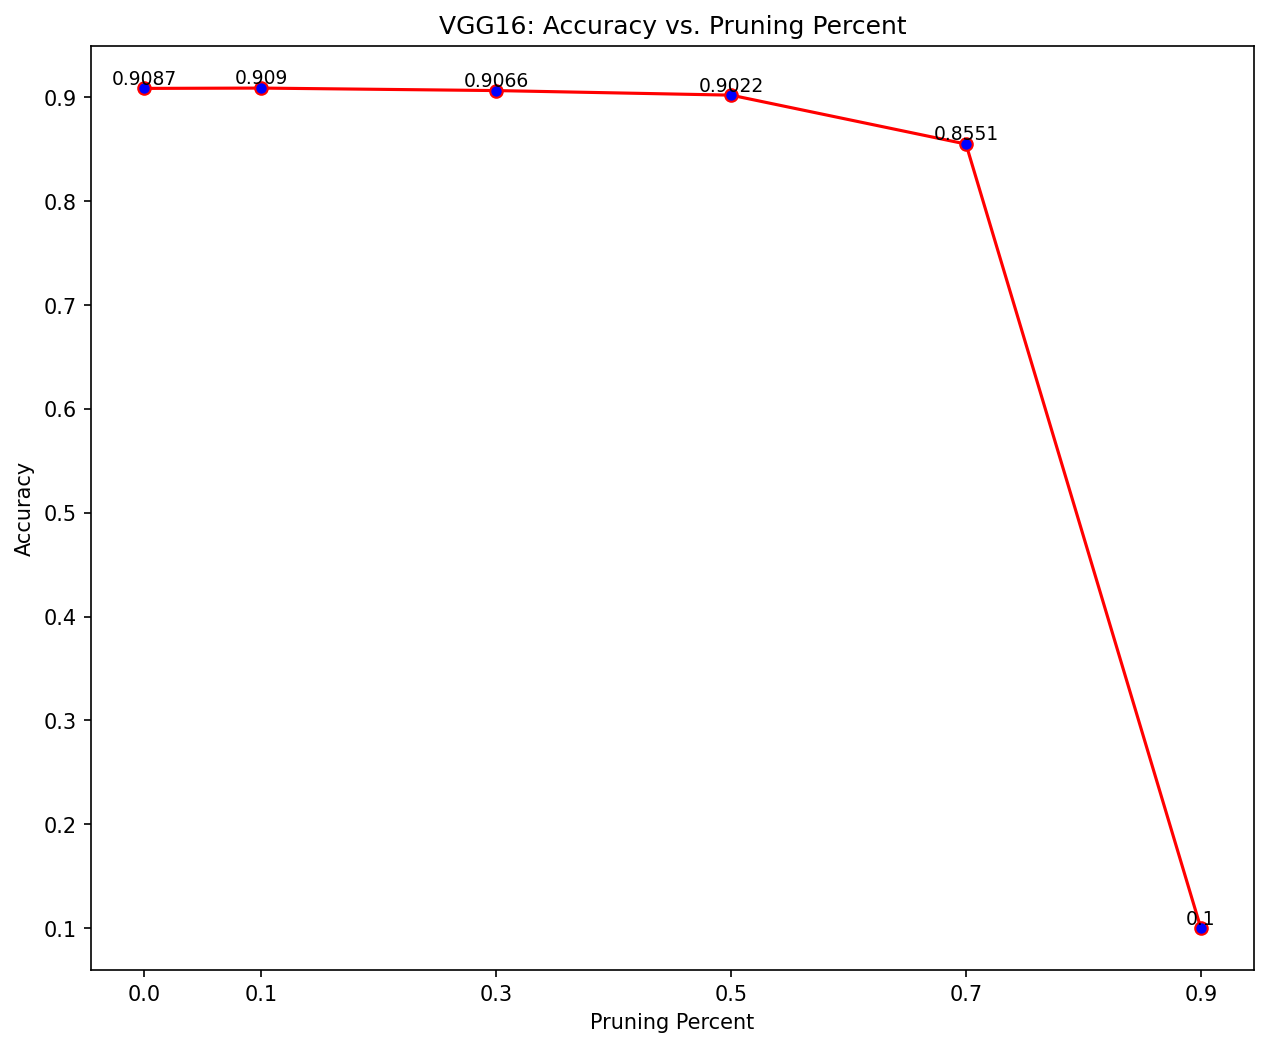

In [47]:
accuracy = [acc, acc1, acc2, acc3, acc4, acc5]
percent = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(10,8),dpi=150)
plt.plot(percent, accuracy, color='r', marker='o', markerfacecolor='blue')
plt.xticks ([0.0, 0.1, 0.3, 0.5, 0.7, 0.9])
plt.title("VGG16: Accuracy vs. Pruning Percent")
plt.xlabel("Pruning Percent")
plt.ylabel("Accuracy")
for a, b in zip(percent, accuracy):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=9)
plt.savefig('VGG16_Accuracy vs. Pruning Percent.png')
plt.show()

In [48]:
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.shape}, non-zero elements: {torch.nonzero(param).shape[0]}')

features.0.weight: torch.Size([64, 3, 3, 3]), non-zero elements: 1728
features.2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 36864
features.5.weight: torch.Size([128, 64, 3, 3]), non-zero elements: 73728
features.7.weight: torch.Size([128, 128, 3, 3]), non-zero elements: 147456
features.10.weight: torch.Size([256, 128, 3, 3]), non-zero elements: 294912
features.12.weight: torch.Size([256, 256, 3, 3]), non-zero elements: 589824
features.14.weight: torch.Size([256, 256, 3, 3]), non-zero elements: 589824
features.17.weight: torch.Size([512, 256, 3, 3]), non-zero elements: 1179648
features.19.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 2359296
features.21.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 2359296
features.24.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 2359296
features.26.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 2359296
features.28.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 2359296
classifier.0.weight:

In [49]:
for name, param in compressed_model1.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.shape}, non-zero elements: {torch.nonzero(param).shape[0]}')

features.0.weight: torch.Size([64, 3, 3, 3]), non-zero elements: 1721
features.2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 35438
features.5.weight: torch.Size([128, 64, 3, 3]), non-zero elements: 70640
features.7.weight: torch.Size([128, 128, 3, 3]), non-zero elements: 140275
features.10.weight: torch.Size([256, 128, 3, 3]), non-zero elements: 277689
features.12.weight: torch.Size([256, 256, 3, 3]), non-zero elements: 547638
features.14.weight: torch.Size([256, 256, 3, 3]), non-zero elements: 549016
features.17.weight: torch.Size([512, 256, 3, 3]), non-zero elements: 1079982
features.19.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 2105389
features.21.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 2103438
features.24.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 2118150
features.26.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 2119858
features.28.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 2090184
classifier.0.weight:

In [50]:
for name, param in compressed_model2.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.shape}, non-zero elements: {torch.nonzero(param).shape[0]}')

features.0.weight: torch.Size([64, 3, 3, 3]), non-zero elements: 1690
features.2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 32364
features.5.weight: torch.Size([128, 64, 3, 3]), non-zero elements: 64357
features.7.weight: torch.Size([128, 128, 3, 3]), non-zero elements: 125658
features.10.weight: torch.Size([256, 128, 3, 3]), non-zero elements: 242818
features.12.weight: torch.Size([256, 256, 3, 3]), non-zero elements: 462580
features.14.weight: torch.Size([256, 256, 3, 3]), non-zero elements: 465367
features.17.weight: torch.Size([512, 256, 3, 3]), non-zero elements: 878224
features.19.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 1597952
features.21.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 1591243
features.24.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 1635249
features.26.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 1637808
features.28.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 1562015
classifier.0.weight: 

In [52]:
for name, param in compressed_model3.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.shape}, non-zero elements: {torch.nonzero(param).shape[0]}')

features.0.weight: torch.Size([64, 3, 3, 3]), non-zero elements: 1660
features.2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 29067
features.5.weight: torch.Size([128, 64, 3, 3]), non-zero elements: 57471
features.7.weight: torch.Size([128, 128, 3, 3]), non-zero elements: 109553
features.10.weight: torch.Size([256, 128, 3, 3]), non-zero elements: 204959
features.12.weight: torch.Size([256, 256, 3, 3]), non-zero elements: 372134
features.14.weight: torch.Size([256, 256, 3, 3]), non-zero elements: 376250
features.17.weight: torch.Size([512, 256, 3, 3]), non-zero elements: 668910
features.19.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 1095475
features.21.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 1082496
features.24.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 1149715
features.26.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 1151854
features.28.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 1055688
classifier.0.weight: 

In [53]:
for name, param in compressed_model4.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.shape}, non-zero elements: {torch.nonzero(param).shape[0]}')

features.0.weight: torch.Size([64, 3, 3, 3]), non-zero elements: 1617
features.2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 25057
features.5.weight: torch.Size([128, 64, 3, 3]), non-zero elements: 49002
features.7.weight: torch.Size([128, 128, 3, 3]), non-zero elements: 90197
features.10.weight: torch.Size([256, 128, 3, 3]), non-zero elements: 160729
features.12.weight: torch.Size([256, 256, 3, 3]), non-zero elements: 269012
features.14.weight: torch.Size([256, 256, 3, 3]), non-zero elements: 273722
features.17.weight: torch.Size([512, 256, 3, 3]), non-zero elements: 442780
features.19.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 606665
features.21.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 592004
features.24.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 662823
features.26.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 660020
features.28.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 579511
classifier.0.weight: torch.

In [22]:
for name, param in compressed_model5.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.shape}, non-zero elements: {torch.nonzero(param).shape[0]}')

features.0.weight: torch.Size([64, 3, 3, 3]), non-zero elements: 1529
features.2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 18478
features.5.weight: torch.Size([128, 64, 3, 3]), non-zero elements: 35367
features.7.weight: torch.Size([128, 128, 3, 3]), non-zero elements: 59935
features.10.weight: torch.Size([256, 128, 3, 3]), non-zero elements: 93927
features.12.weight: torch.Size([256, 256, 3, 3]), non-zero elements: 129727
features.14.weight: torch.Size([256, 256, 3, 3]), non-zero elements: 133591
features.17.weight: torch.Size([512, 256, 3, 3]), non-zero elements: 176377
features.19.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 158584
features.21.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 153515
features.24.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 184946
features.26.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 175174
features.28.weight: torch.Size([512, 512, 3, 3]), non-zero elements: 149896
classifier.0.weight: torch.S